In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def mean_absolute_percentage_error(y_true,y_pred):
    """ Function to calculate MAPE"""
    mape = np.mean(np.abs((y_true-y_pred)/y_true)) * 100
    return round(mape,2)

def mean_squared_error(y_true,y_pred):
    """Function to calculate MSE"""
    mse = ((y_pred-y_true)**2).mean()
    return round(mse,2)

def root_mean_squared_error(y_true,y_pred):
    """Function to calculate RMSE"""
    mse = ((y_pred-y_true)**2).mean()
    return round(np.sqrt(mse),2)

In [4]:
data = pd.read_csv('Port Harcourt, Nigeria (4.80678 7.002953).csv', parse_dates=['created_at'] )
data.head()

,created_at,entry_id,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3
0,2021-07-26 16:45:59+00:00,198,89,50,40.78
1,2021-07-26 16:48:03+00:00,199,89,50,40.09
2,2021-07-26 16:49:59+00:00,200,89,50,37.93
3,2021-07-26 16:54:03+00:00,201,89,50,33.18
4,2021-07-26 16:55:59+00:00,202,89,50,37.84


In [5]:
# Check data columns
data.columns

Index(['created_at', 'entry_id', 'Temperature_F', 'Humidity_%',
       'PM2.5_ATM_ug/m3'],
      dtype='object')

In [6]:

drop_cols = ['entry_id', 'Temperature_F', 'Humidity_%']
data.drop(drop_cols, axis=1, inplace=True)
data.rename(columns={'PM2.5_ATM_ug/m3': 'PM'},inplace=True, errors='raise')
data['created_at'] = data['created_at'].astype('datetime64[ns]')
data.head()

,created_at,PM
0,2021-07-26 16:45:59,40.78
1,2021-07-26 16:48:03,40.09
2,2021-07-26 16:49:59,37.93
3,2021-07-26 16:54:03,33.18
4,2021-07-26 16:55:59,37.84


In [7]:
# check for missing data
data.isnull().sum()

created_at    0
PM            0
dtype: int64

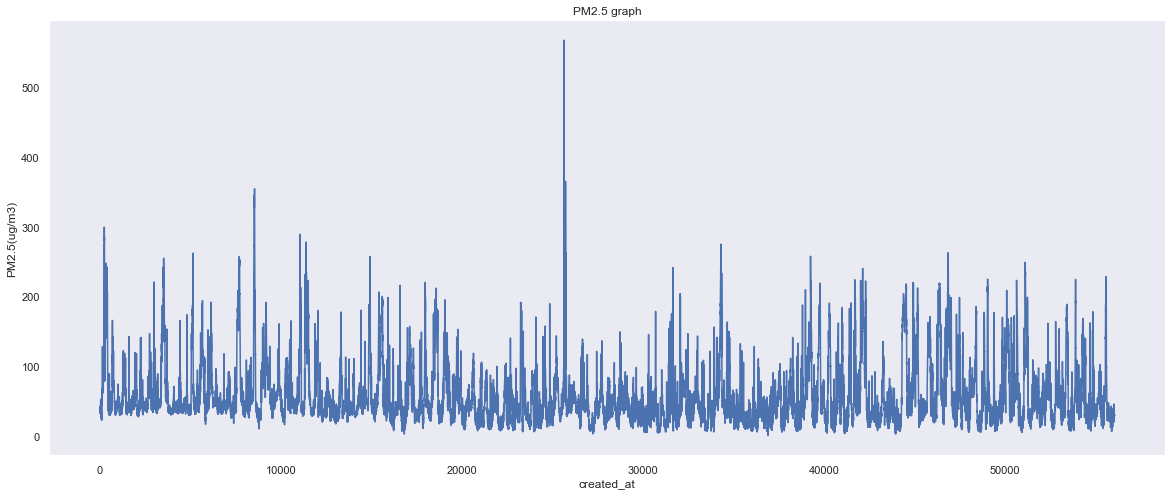

In [8]:
# Plot the time series
plt.figure(figsize=(20, 8))
plt.plot(data['PM'])
plt.title('PM2.5 graph')
plt.ylabel('PM2.5(ug/m3)')
plt.xlabel('created_at')
plt.grid(False)
plt.show()

Not much can be seen on this graph above in terms of seasonality or if it's stationary. Might do a data slice to view or better still do a groupby the maximum data or average in a day.

In [9]:
df_sampled = data.resample('D', on='created_at').PM.mean() # a series
df_copy = df_sampled.copy().reset_index()
df = df_copy.set_index(['created_at']) # a dataframe
df.head()

,PM
created_at,
2021-07-26,55.164698
2021-07-27,97.020537
2021-07-28,54.527722
2021-07-29,45.996642
2021-07-30,53.224902


## Visualizing the time series data

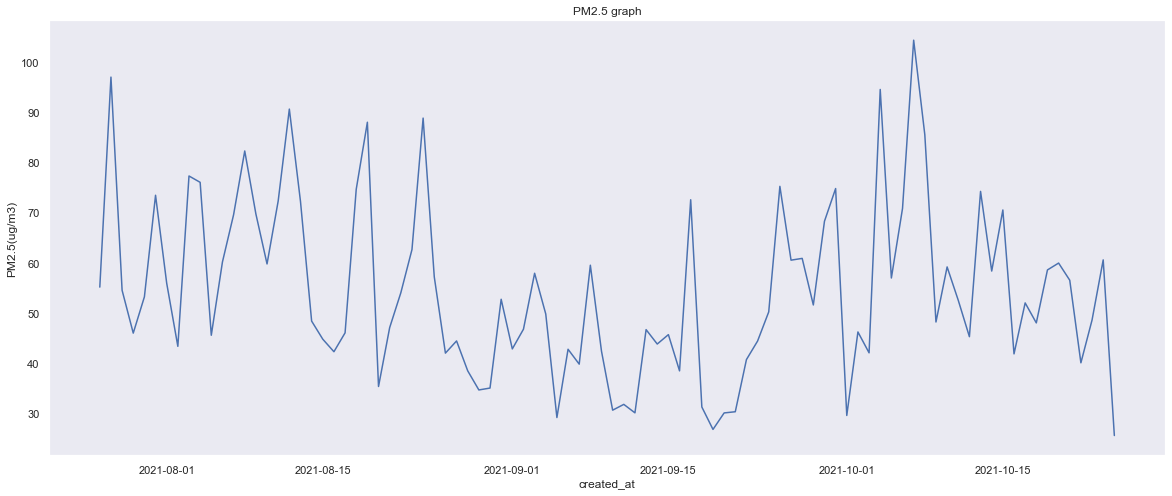

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(df['PM'])
plt.title('PM2.5 graph')
plt.ylabel('PM2.5(ug/m3)')
plt.xlabel('created_at')
plt.grid(False)
plt.show()

This looks better than the previous graph, There seems to be some seasonality but not sure about stationary. We can check if its stationary with the Dicker Fuller test.

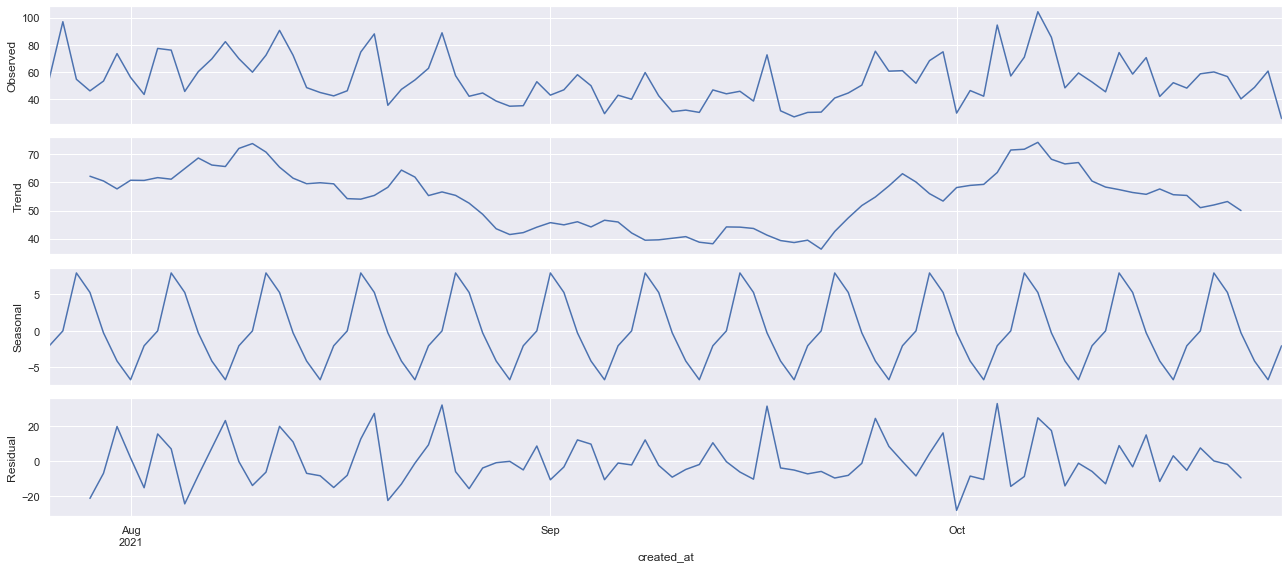

In [11]:
from pylab import rcParams
rcParams['figure.figsize']= 18,8

decomposition = sm.tsa.seasonal_decompose(df['PM'], model='additive')
fig = decomposition.plot()
plt.show()

The plot above shows that the there is no trend in the data, We can see that the `PM2.5` got lower in september than in August and October, maybe with a full year data we can see better on the trend. There seems to be some obvious seasonality.

## Moving Average

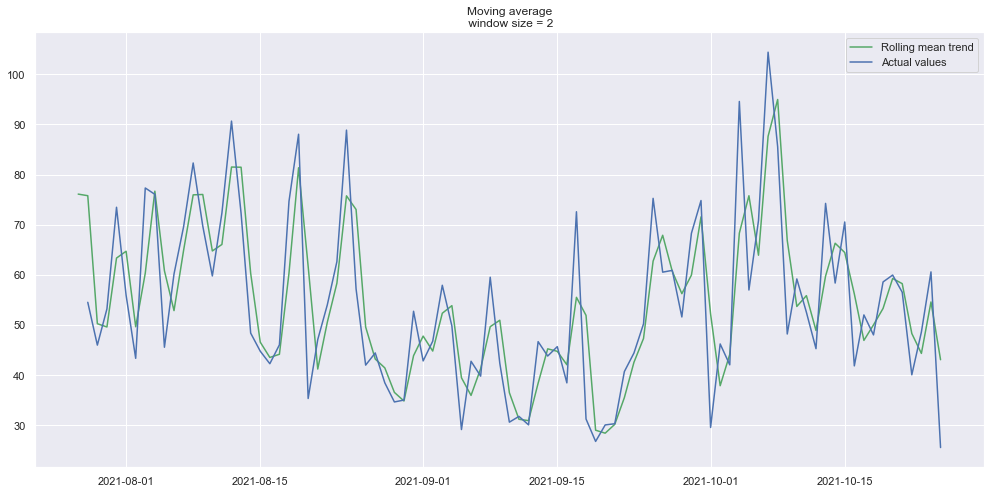

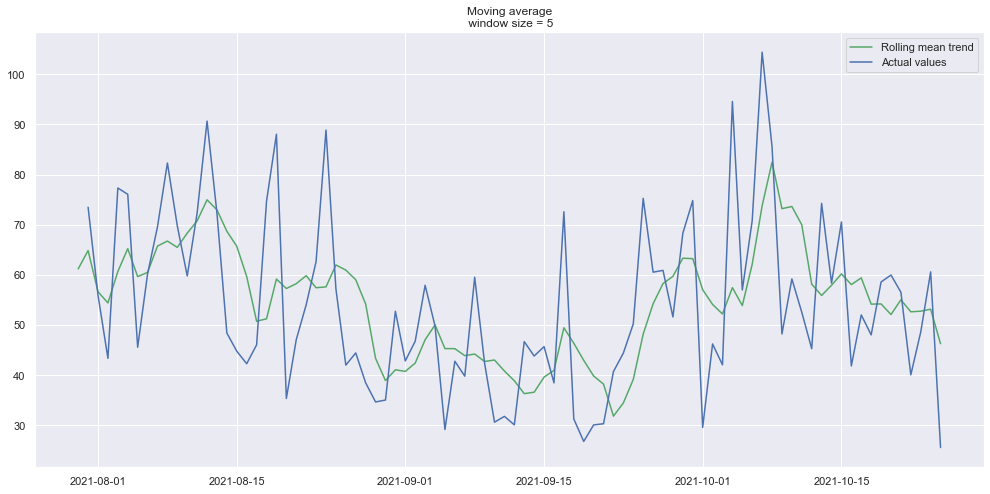

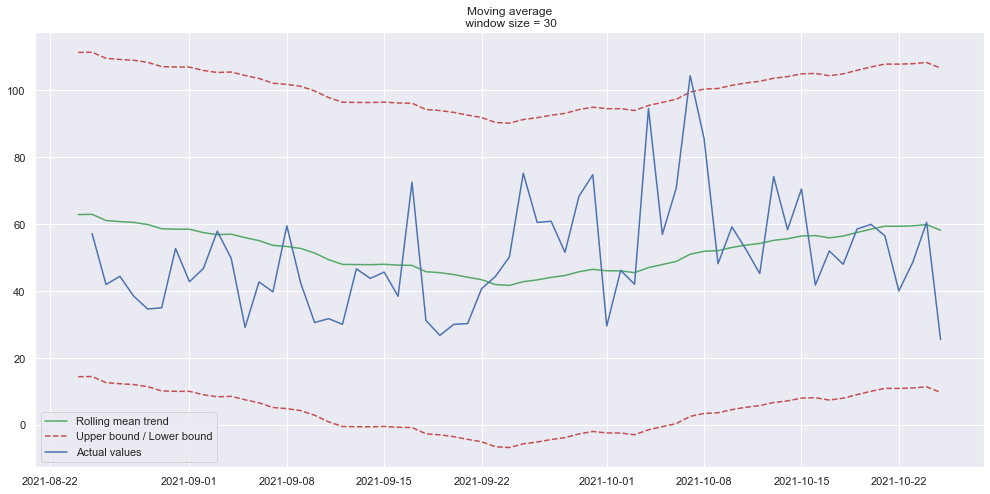

In [12]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 2 days
plot_moving_average(df.PM, 2)

#Smooth by the previous week (7 days)
plot_moving_average(df.PM, 5)

#Smooth by previous month (30 days)
plot_moving_average(df.PM, 30, plot_intervals=True)

The MA graphs shows a downward trend at the end.This might mean that the PM2.5 values will likely go down in the following days.

## Exponential Smoothing

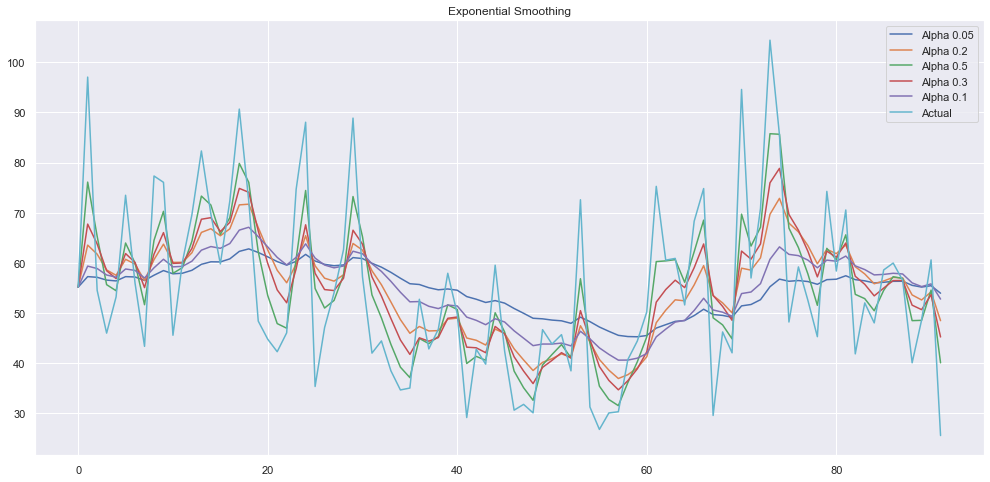

In [13]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df.PM, [0.05, 0.2,0.5,0.3, 0.1])

An alpha value of 0.5 smoothed the curve while picking up most of the upward and downward trends.

## Double Exponential Smoothing

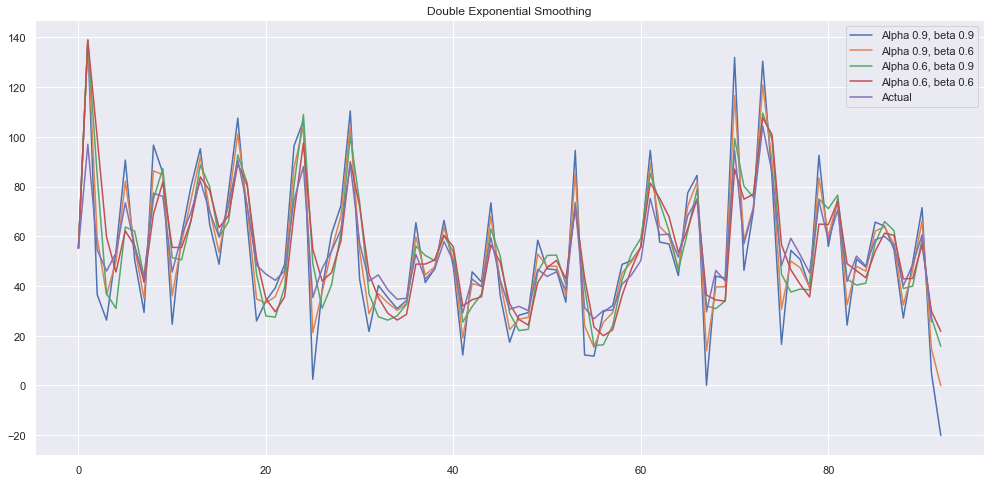

In [14]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df.PM, alphas=[0.9, 0.6], betas=[0.9, 0.6])

The double smoothing works perfectly for the data, especially alpha  = 0.9, beta = 0.9

## Modelling

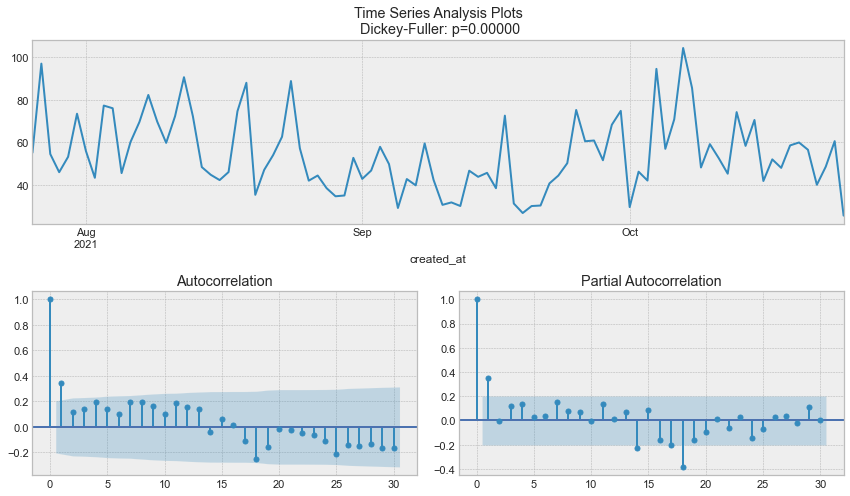

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.PM, lags=30)

From the chart above, the Dicker Fuller test gives a result that p=0, which indicates that the data is stationary. We can also see seasonality though not too consistent in the data.

## Seasonal ARIMA

In [16]:
# Uncomment to run, the best value is used below.
# #Set initial values and some bounds
# ps = range(0, 5)
# d = 1
# qs = range(0, 5)
# Ps = range(0, 5)
# D = 1
# Qs = range(0, 5)
# s = 2

# #Create a list with all possible combinations of parameters
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)

# # Train many SARIMA models to find the best set of parameters
# def optimize_SARIMA(parameters_list, d, D, s):
#     """
#         Return dataframe with parameters and corresponding AIC
        
#         parameters_list - list with (p, q, P, Q) tuples
#         d - integration order
#         D - seasonal integration order
#         s - length of season
#     """
    
#     results = []
#     best_aic = float('inf')
    
#     for param in tqdm_notebook(parameters_list):
#         try: model = sm.tsa.statespace.SARIMAX(df.PM, order=(param[0], d, param[1]),
#                                                seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
#         except:
#             continue
            
#         aic = model.aic
        
#         #Save best model, AIC and parameters
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])
        
#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
#     #Sort in ascending order, lower AIC is better
#     result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
#     return result_table

# result_table = optimize_SARIMA(parameters_list, d, D, s)

# #Set parameters that give the lowest AIC (Akaike Information Criteria)
# p, q, P, Q = result_table.parameters[0]

# best_model = sm.tsa.statespace.SARIMAX(df.PM, order=(p, d, q),
#                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

# print(best_model.summary())

In [17]:
model = sm.tsa.statespace.SARIMAX(df_sampled, order=(2,1,2),
                                               seasonal_order=(0,1,1,2))
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1878      0.120      9.868      0.000       0.952       1.424
ar.L2         -0.3942      0.132     -2.992      0.003      -0.652      -0.136
ma.L1         -1.8901      0.114    -16.550      0.000      -2.114      -1.666
ma.L2          0.9719      0.116      8.369      0.000       0.744       1.199
ma.S.L2       -0.9986      2.825     -0.353      0.724      -6.536       4.539
sigma2       246.9021    703.117      0.351      0.725   -1131.182    1624.986


In [18]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

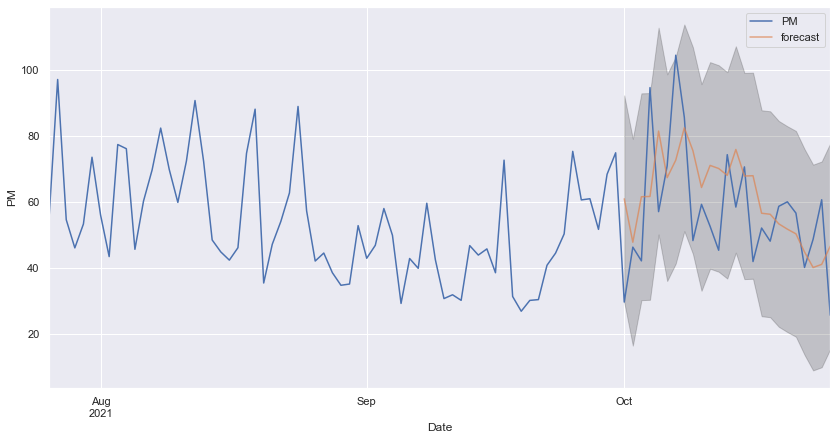

In [19]:
ax = df['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label ='forecast', alpha=0.7,figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('PM')
plt.legend()
plt.show()

## Model Evaluation

In [20]:
y_predict = pred.predicted_mean
y_truth = df_sampled['2021-10-01':]
print(f"MAPE is:", mean_absolute_percentage_error(y_truth,y_predict))
print(f"MSE is:", mean_squared_error(y_truth,y_predict))
print(f"RMSE is:", root_mean_squared_error(y_truth,y_predict))

MAPE is: 29.38
MSE is: 318.63
RMSE is: 17.85


The RMSE indicates that the model was able to forecast the avearge daily `PM` within 17.85 of the real PM.

## Producing and visualizing forecast

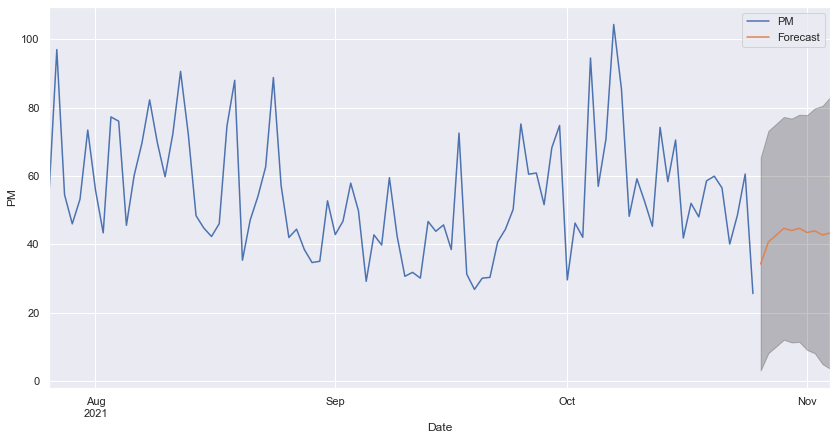

In [21]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM')
plt.legend()
plt.show()

From the model forecast, in the next 10 days, we expect the PM value to go up sharply and then stabilizes around a average value of 45.0 ug/m3.

In [23]:
pred_uc.predicted_mean

2021-10-26    34.249544
2021-10-27    40.696499
2021-10-28    42.674322
2021-10-29    44.693767
2021-10-30    44.048746
2021-10-31    44.698074
2021-11-01    43.459530
2021-11-02    43.943957
2021-11-03    42.743502
2021-11-04    43.338170
Freq: D, dtype: float64